In [119]:
import json
import requests
import pandas as pd
import graphlab as gl
from py2neo import authenticate, Graph
import networkx as nx
import urllib2

import matplotlib.pyplot as plt



In [120]:
gl.canvas.set_target('browser')
url = "https://raw.githubusercontent.com/manlius/StarWars-social-network/master/networks/starwars-episode-4-interactions-allCharacters.json"
import json

response = urllib2.urlopen(url)
  
print response


<addinfourl at 4955249192 whose fp = <socket._fileobject object at 0x127bafbd0>>


In [121]:

graph = json.load(response)

In [122]:
nodes_df = pd.DataFrame(graph["nodes"])
nodes_df.rename(columns={'value': 'id', }, inplace=True)
nodes_df.sort_values(by='id', inplace=True)



nodes_df = nodes_df[nodes_df.name != 'GREEDO']
nodes_df = nodes_df[nodes_df.name != 'CAMIE']
nodes_df = nodes_df[nodes_df.name != 'MOTTI']
nodes_df = nodes_df[nodes_df.name != 'RED TEN']


nodes_df

,colour,name,id
15,#808080,JABBA,3
16,#808080,DODONNA,4
8,#808080,BERU,6
9,#808080,OWEN,7
21,#808080,GOLD FIVE,9
12,#808080,TARKIN,13
17,#808080,GOLD LEADER,15
18,#808080,WEDGE,16
6,#808080,BIGGS,19
10,#48D1CC,OBI-WAN,23


In [123]:
edges_df = pd.DataFrame(graph["links"])
edges_df


,source,target,value
0,2,0,17
1,3,0,13
2,10,0,6
3,7,0,5
4,13,0,5
5,1,0,3
6,16,0,1
7,1,10,7
8,2,1,5
9,1,3,16


In [124]:
authenticate("localhost:7474", "neo4j", "graphdb")
graph = Graph()
statement = "CREATE (n:Person { name: {name}, id: {id} })" 

SocketError: Connection refused

In [125]:
tx = graph.begin()

AttributeError: 'dict' object has no attribute 'begin'

In [126]:
for index, row in nodes_df.iterrows():

    tx.append(statement, {"name": row['name'] , "id": row['id']   })
    tx.process
    
tx.commit()

NameError: name 'tx' is not defined

In [127]:
g = nx.Graph()
g.clear()

In [128]:
merged_df = pd.merge(edges_df, nodes_df , left_on=['source'] , right_on =['id'] )
merged_df= pd.merge(merged_df, nodes_df , left_on=['target'] , right_on =['id'] )
merged_df.rename(columns={'name_x': 'source_name', }, inplace=True)
merged_df.rename(columns={'name_y': 'target_name', }, inplace=True)
merged_df


,source,target,value,colour_x,source_name,id_x,colour_y,target_name,id_y
0,3,9,3,#808080,JABBA,3,#808080,GOLD FIVE,9
1,3,19,3,#808080,JABBA,3,#808080,BIGGS,19
2,7,19,1,#808080,OWEN,7,#808080,BIGGS,19
3,6,19,3,#808080,BERU,6,#808080,BIGGS,19
4,7,3,17,#808080,OWEN,7,#808080,JABBA,3
5,13,3,26,#808080,TARKIN,13,#808080,JABBA,3
6,16,3,1,#808080,WEDGE,16,#808080,JABBA,3
7,6,3,4,#808080,BERU,6,#808080,JABBA,3
8,13,15,1,#808080,TARKIN,13,#808080,GOLD LEADER,15
9,13,7,13,#808080,TARKIN,13,#808080,OWEN,7


In [129]:
#statement =  "MATCH (name:{from}),(name:{to})  CREATE (from)-[r:MENTIONS{times:{times}]->(to) "
statement = "MATCH (a:Person),(b:Person)  WHERE a.id = {to}  AND b.id  = {from} CREATE (a)-[r:mentions{times:{times}}] ->(b)"
statement

'MATCH (a:Person),(b:Person)  WHERE a.id = {to}  AND b.id  = {from} CREATE (a)-[r:mentions{times:{times}}] ->(b)'

In [130]:
tx = graph.begin()
for index, row in edges_df.iterrows():
    tx.append(statement, {"from": row['source'] , "to": row['target'] , "times":row['value'] })
    tx.process()

    
tx.commit()


AttributeError: 'dict' object has no attribute 'begin'

In [131]:
for index, row in merged_df.iterrows(): 
    print row['value']
    g.add_edge(row['source_name'], row['target_name'], weight = row['value']   )

3
3
1
3
17
26
1
4
1
13
1
1


In [132]:
merged_df

,source,target,value,colour_x,source_name,id_x,colour_y,target_name,id_y
0,3,9,3,#808080,JABBA,3,#808080,GOLD FIVE,9
1,3,19,3,#808080,JABBA,3,#808080,BIGGS,19
2,7,19,1,#808080,OWEN,7,#808080,BIGGS,19
3,6,19,3,#808080,BERU,6,#808080,BIGGS,19
4,7,3,17,#808080,OWEN,7,#808080,JABBA,3
5,13,3,26,#808080,TARKIN,13,#808080,JABBA,3
6,16,3,1,#808080,WEDGE,16,#808080,JABBA,3
7,6,3,4,#808080,BERU,6,#808080,JABBA,3
8,13,15,1,#808080,TARKIN,13,#808080,GOLD LEADER,15
9,13,7,13,#808080,TARKIN,13,#808080,OWEN,7


In [155]:
nodes_list = g.nodes() 
zero_degree_node_list = []

degree = nx.degree(g, weight='weight')  #need to get degree before adding nodes that are not in list

for index, row in nodes_df.iterrows(): 
    if row['name'] not in nodes_list:
        g.add_node(row['name'])
        zero_degree_node_list.append(row['name'])
        

g.nodes()
degree

{u'BERU': 8,
 u'BIGGS': 7,
 u'C-3PO': 0,
 u'CHEWBACCA': 0,
 u'DARTH VADER': 0,
 u'DODONNA': 1,
 u'GOLD FIVE': 3,
 u'GOLD LEADER': 1,
 u'HAN': 0,
 u'JABBA': 54,
 u'LEIA': 0,
 u'LUKE': 0,
 u'OBI-WAN': 0,
 u'OWEN': 33,
 u'R2-D2': 0,
 u'RED LEADER': 0,
 u'TARKIN': 40,
 u'WEDGE': 1}

In [134]:
g.edges()

[(u'BERU', u'JABBA'),
 (u'BERU', u'OWEN'),
 (u'BERU', u'BIGGS'),
 (u'WEDGE', u'JABBA'),
 (u'DODONNA', u'OWEN'),
 (u'GOLD LEADER', u'TARKIN'),
 (u'TARKIN', u'JABBA'),
 (u'TARKIN', u'OWEN'),
 (u'OWEN', u'JABBA'),
 (u'OWEN', u'BIGGS'),
 (u'GOLD FIVE', u'JABBA'),
 (u'JABBA', u'BIGGS')]

In [135]:

degree

{u'BERU': 3,
 u'BIGGS': 3,
 u'DODONNA': 1,
 u'GOLD FIVE': 1,
 u'GOLD LEADER': 1,
 u'JABBA': 6,
 u'OWEN': 5,
 u'TARKIN': 3,
 u'WEDGE': 1}

In [136]:
for key, value in sorted(degree.iteritems(), key=lambda (k,v): (v,k), reverse = True):
    print "%s: %s" % (key, value)

JABBA: 6
OWEN: 5
TARKIN: 3
BIGGS: 3
BERU: 3
WEDGE: 1
GOLD LEADER: 1
GOLD FIVE: 1
DODONNA: 1


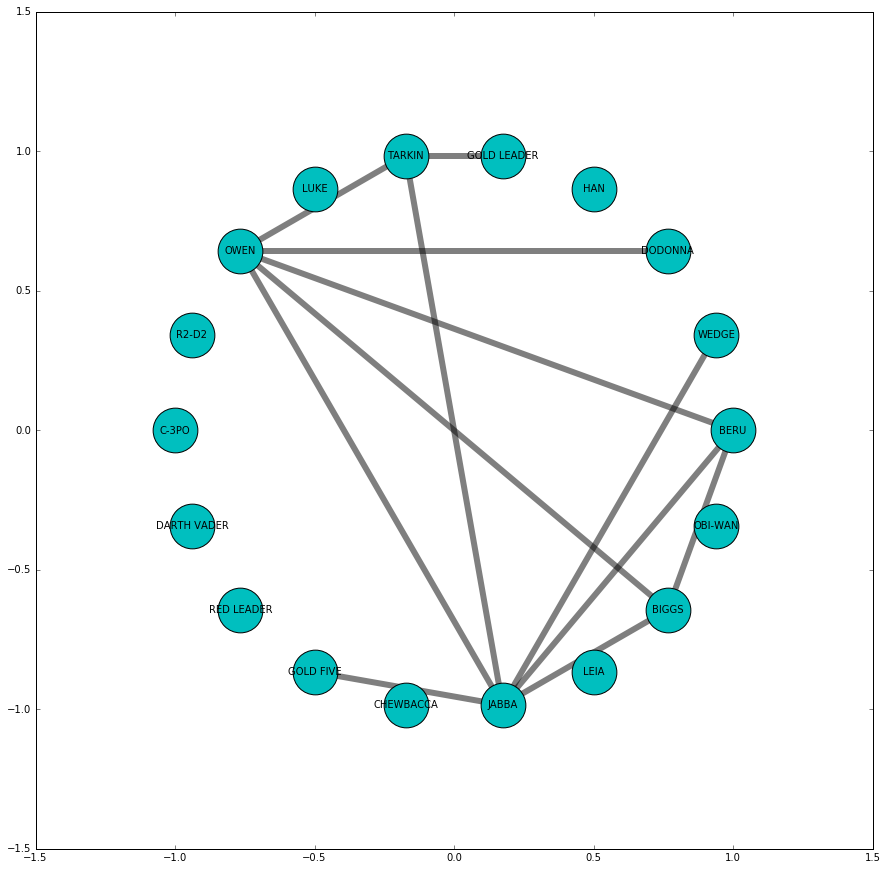

In [154]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline 

fig_size[0] = 15
fig_size[1] = 15
plt.rcParams["figure.figsize"] = fig_size
 
pos = nx.circular_layout(g)
# nodes
nx.draw_networkx_nodes(g,pos,node_size=2000, node_color='c')

# edges
nx.draw_networkx_edges(g,pos,alpha=0.5,width=6)

nx.draw_networkx_labels(g,pos,font_size=10,font_family='sans-serif')

plt.show()


[6.0, 4.0]